<a href="https://www.kaggle.com/code/ankitaguha/showcasing-agile-safety-classifiers-with-gemma?scriptVersionId=175899614" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/gemma/keras/gemma_instruct_2b_en/2/config.json
/kaggle/input/gemma/keras/gemma_instruct_2b_en/2/tokenizer.json
/kaggle/input/gemma/keras/gemma_instruct_2b_en/2/metadata.json
/kaggle/input/gemma/keras/gemma_instruct_2b_en/2/model.weights.h5
/kaggle/input/gemma/keras/gemma_instruct_2b_en/2/assets/tokenizer/vocabulary.spm


## Overview
This codelab illustrates how to create a customised text classifier using parameter efficient tuning (PET). Instead of fine-tuning the whole model, PET methods update only a small amount of parameters, which makes it relatively easy and fast to train. It also makes it easier for a model to learn new behaviors with relatively little training data. The methodology is described in detail in [Towards Agile Text Classifiers for Everyone](https://arxiv.org/abs/2302.06541) which shows how these techniques can be applied to a variety of safety tasks and achieve state of the art performance with only a few hundred training examples.

This codelab uses the [LoRA](https://arxiv.org/abs/2106.09685) PET method and the smaller Gemma model (gemma_instruct_2b_en) since that can be run faster and more efficiently. The colab covers the steps of ingesting data, formatting it for the LLM, training LoRA weights, and then evaluating the results. This codelab trains on the [ETHOS](https://arxiv.org/abs/2006.08328) dataset, a publicly available dataset for detecting hateful speech, built from YouTube and Reddit comments. When trained on only 200 examples (1/4 of the dataset) it achieves F1: 0.80 and ROC-AUC: 0.78, slightly above the SOTA currently reported on the [leaderboard](https://paperswithcode.com/sota/hate-speech-detection-on-ethos-binary) (at the time of writing, 15 Feb 2024). When trained on the full 800 examples, like it achieves an F1 score of 83.74 and a ROC-AUC score of 88.17. Larger models, like gemma_instruct_7b_en will generally perform better, but training and execution costs are also larger.

Trigger Warning: because this codelab develops a safety classifier for detecting hateful speech, examples and evaluation of the results contains some horrible language.

In [2]:
#pip install upgrade pip
!pip install wurlitzer
!pip install -q -U keras-nlp
!pip install -q -U keras



ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.3.3 which is incompatible.


# 1. Loading the Dataset
In this section you will load the dataset on which to train our classifier and preprocess it into a train and test set. You will use the popular research dataset ETHOS which was collected to detect hate speech in social media. You can find more information about how the dataset was collected in the paper [ETHOS: an Online Hate Speech Detection Dataset.](https://arxiv.org/abs/2006.08328)

In [3]:
import pandas as pd

gh_root = 'https://raw.githubusercontent.com'
gh_repo = 'intelligence-csd-auth-gr/Ethos-Hate-Speech-Dataset'
gh_path = 'master/ethos/ethos_data/Ethos_Dataset_Binary.csv'
data_url = f'{gh_root}/{gh_repo}/{gh_path}'

df = pd.read_csv(data_url, delimiter=';')
df['hateful'] = (df['isHate'] >= df['isHate'].median()).astype(int)

# Shuffle the dataset.
df = df.sample(frac=1, random_state=32)

# Split into train and test.
df_train, df_test = df[:800],  df[800:]

# Display a sample of the data.
df.head(5)[['hateful', 'comment']]

,hateful,comment
517,0,You said he but still not convinced this is a ...
685,0,"well, looks like its time to have another child"
706,0,to be honest I am part of the LGBT community a...
182,1,What if we send every men to mars to start a n...
829,0,"It doesn't matter if you're black or white, ..."


# 2. Download and Instantiate the Model
As described in the documentation, you can easily use the Gemma model in many ways. With Keras, this is what you need to do:

In [4]:
import keras
import keras_nlp

# For reproducibility purposes.
keras.utils.set_random_seed(1234)

# Download the model from Kaggle using Keras.
model = keras_nlp.models.GemmaCausalLM.from_preset('gemma_instruct_2b_en')

# Set the sequence length to a small enough value to fit in memory in Colab.
model.preprocessor.sequence_length = 128

2024-05-05 21:00:08.720803: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-05 21:00:08.720900: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-05 21:00:08.842066: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
Attaching 'metadata.json' from model 'keras/gemma/keras/gemma_instruct_2b_en/2' to your Kaggle notebook...
Attaching 'metadata.json' from model 'keras/gemma/keras/gemma_instruct_2b_en/2' to your Kaggle notebook...
Attaching 'task.json' from model 'keras/gemma/keras/gemma_instruct_2b_en/2' to your Kaggle notebook...
Attaching 'config.json' from model 'keras/gemma/

Let's test that the model is working by generating some text:

In [5]:
model.generate('Question: what is the capital of France? ', max_length=32)

I0000 00:00:1714942977.502809      34 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1714942977.568780      34 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1714942977.637419      34 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


'Question: what is the capital of France? \n\nAnswer: Paris. \n\nParis is the capital city of France and is known as the City of'

# 3. Text Preprocessing and Separator Tokens
To help the model understand our intent better, you can preprocess the text and use separator tokens. This makes it less likely for the model to generate text that does not fit the expected format. For example, you might attempt to request a sentiment classification from the model by writing a prompt like this:
Classify the following text into one of the following classes:[Positive,Negative]

Text: you look very nice today ImageClassification:

In this case, the model may or may not output what you are looking for. For example, if the text contains newline characters, it's likely to have a negative effect on the model performance. A more robust approach is to use separator tokens. The prompt then becomes:

Classify the following text into one of the following classes:[Positive,Negative]
<separator>

Text: you look very nice today
<separator>
Prediction:
    
This can be abstracted using a function that preprocesses the text:

In [7]:
def preprocess_text(
    text: str,
    labels: list[str],
    instructions: str,
    separator: str,
) -> str:
  prompt = f'{instructions}:[{",".join(labels)}]'
  return separator.join([prompt, f'Text:{text}', 'Prediction:'])

Now, if you run the function using the same prompt and text as before, you should get the same output:

In [8]:
text = 'you look very nice today'

prompt = preprocess_text(
    text=text,
    labels=['Positive', 'Negative'],
    instructions='Classify the following text into one of the following classes',
    separator='\n<separator>\n',
)

print(prompt)

Classify the following text into one of the following classes:[Positive,Negative]
<separator>
Text:you look very nice today
<separator>
Prediction:


# 4. Output Postprocessing
The outputs of the model are tokens with various probabilities. Normally, to generate text, you would select among the top few most probable tokens and construct sentences, paragraphs or even full documents. However, for the purpose of classification, what actually matters is whether the model believes that Positive is more probable than Negative or vice versa.

Given the model you instantiated earlier, this is how you can process its output into the independent probabilities of whether the next token is Positive or Negative:

In [9]:
import numpy as np


def softmax_normalization(arr: np.ndarray) -> np.ndarray:
  """Normalizes logits values into probabilities summing to one."""
  arr_exp = np.exp(arr - np.max(arr))
  return arr_exp / arr_exp.sum()


def compute_token_probability(
    model: keras_nlp.models.GemmaCausalLM,
    prompt: str,
    target_tokens: list[str],
) -> dict[str, float]:
  # Shorthands.
  preprocessor = model.preprocessor
  tokenizer = preprocessor.tokenizer

  # Identify output token offset.
  (padding_mask,) = preprocessor.generate_preprocess([prompt])['padding_mask']
  token_offset = sum(padding_mask.numpy()) - 1

  # Compute prediction, extract only the next token's logits.
  (logits,) = model.predict([prompt], verbose=0)
  token_logits = logits[token_offset]

  # Identify the token indices, which is the same as the ID for this tokenizer.
  # NOTE: If a token is not found, it will be considered same as "<unk>".
  token_ids = [tokenizer.token_to_id(token) for token in target_tokens]

  # Compute the relative probability of each of the requested tokens.
  probabilities = softmax_normalization([token_logits[ix] for ix in token_ids])

  return dict(zip(target_tokens, probabilities))

You can test that function by running it with a the prompt you created earlier:

In [10]:
compute_token_probability(
    model=model,
    prompt=prompt,
    target_tokens=['Positive', 'Negative'],
)

W0000 00:00:1714943182.896105     116 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


{'Positive': 0.99994016, 'Negative': 5.9841288e-05}

# 5. Wrapping it all as a Classifier
For ease of use, you can wrap all of the functions you just created into a single sklearn-like classifier with easy to use and familiar functions like predict() and predict_score().

In [11]:
import dataclasses


@dataclasses.dataclass(frozen=True)
class AgileClassifier:
  """Agile classifier to be wrapped around a LLM."""

  # The classes whose probability will be predicted.
  labels: tuple

  # Provide default instructions and control tokens, can be overridden by user.
  instructions: str = 'Classify the following text into one of the following classes'
  separator_token: str = '<separator>'
  end_of_text_token: str = '<eos>'

  def encode_for_prediction(self, x_text: str) -> str:
    return preprocess_text(
        text=x_text,
        labels=self.labels,
        instructions=self.instructions,
        separator=self.separator_token,
    )

  def encode_for_training(self, x_text: str, y: int) -> str:
    return ''.join([
        self.encode_for_prediction(x_text),
        self.labels[y],
        self.end_of_text_token,
    ])

  def predict_score(
      self,
      model: keras_nlp.models.GemmaCausalLM,
      x_text: str,
  ) -> list[float]:
    prompt = self.encode_for_prediction(x_text)
    token_probabilities = compute_token_probability(
        model=model,
        prompt=prompt,
        target_tokens=self.labels,
    )
    return [token_probabilities[token] for token in self.labels]

  def predict(
      self,
      model: keras_nlp.models.GemmaCausalLM,
      x_eval: str,
  ) -> int:
    return np.argmax(self.predict_score(model, x_eval))


agile_classifier = AgileClassifier(labels=('Positive', 'Negative'))

# 6. Model Fine-Tuning
LoRA stands for Low-Rank Adaptation. It's a fine-tuning technique that can be used to efficiently fine-tune large language models. You can read more about it in the [LoRA: Low-Rank Adaptation of Large Language Models paper](https://arxiv.org/abs/2106.09685).

The Keras implementation of Gemma provides a enable_lora() method that you can use for fine-tuning:

In [12]:
# Enable LoRA for the model and set the LoRA rank to 4.
model.backbone.enable_lora(rank=4)

Training for more epochs will result in higher accuracy, until overfitting occurs.

In [13]:
import tensorflow as tf

# Create dataset with preprocessed text + labels.
map_fn = lambda xy: agile_classifier.encode_for_training(*xy)
x_train = list(map(map_fn, df_train[['comment', 'hateful']].values))
ds_train = tf.data.Dataset.from_tensor_slices(x_train).batch(2)

# Compile the model using the Adam optimizer and appropriate loss function.
model.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=keras.optimizers.Adam(learning_rate=0.0005),
    weighted_metrics=[keras.metrics.SparseCategoricalAccuracy()],
)

# Begin training.
model.fit(ds_train, epochs=4)

Epoch 1/4


W0000 00:00:1714943307.579431     117 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


400/400 ━━━━━━━━━━━━━━━━━━━━ 355s 736ms/step - loss: 1.1365 - sparse_categorical_accuracy: 0.5874
Epoch 2/4
400/400 ━━━━━━━━━━━━━━━━━━━━ 294s 734ms/step - loss: 0.7579 - sparse_categorical_accuracy: 0.6662
Epoch 3/4
400/400 ━━━━━━━━━━━━━━━━━━━━ 294s 735ms/step - loss: 0.6818 - sparse_categorical_accuracy: 0.6894
Epoch 4/4
400/400 ━━━━━━━━━━━━━━━━━━━━ 294s 734ms/step - loss: 0.5922 - sparse_categorical_accuracy: 0.7219


# 7. Inspect the Results
You can now inspect the output of the agile classifier you just trained. This code will output the predicted class score given a piece of text:

In [14]:
text = 'you look really nice today'
scores = agile_classifier.predict_score(model, text)
dict(zip(agile_classifier.labels, scores))

W0000 00:00:1714944522.344539     117 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


{'Positive': 0.99900454, 'Negative': 0.0009954689}

# 8. Model Evaluation
Finally, you'll evaluate the performance of our model using two common metrics, the F1 score and the AUC-ROC. The F1 score captures false negative and false positive errors by evaluating the harmonic mean of the precision and recall at a certain classification threshold. The AUC-ROC on the other hand captures the tradeoff between the true positive rate and the false positive rate across a variety of thresholds and computes the area under this curve.

In [15]:
from sklearn.metrics import f1_score, roc_auc_score

y_true = df_test['hateful'].values
# Compute the scores (aka probabilities) for each of the labels.
y_score = [agile_classifier.predict_score(model, x) for x in df_test['comment']]
# The label with highest score is considered the predicted class.
y_pred = np.argmax(y_score, axis=1)
# Extract the probability of a comment being considered hateful.
y_prob = [x[agile_classifier.labels.index('Negative')] for x in y_score]

# Compute F1 and AUC-ROC scores.
print(f'F1: {f1_score(y_true, y_pred):.2f}')
print(f'AUC-ROC: {roc_auc_score(y_true, y_prob):.2f}')

F1: 0.84
AUC-ROC: 0.88


Another interesting way to evaluate model predictions are confusion matrices. A confusion matrix will visually depict the different kinds of prediction errors.

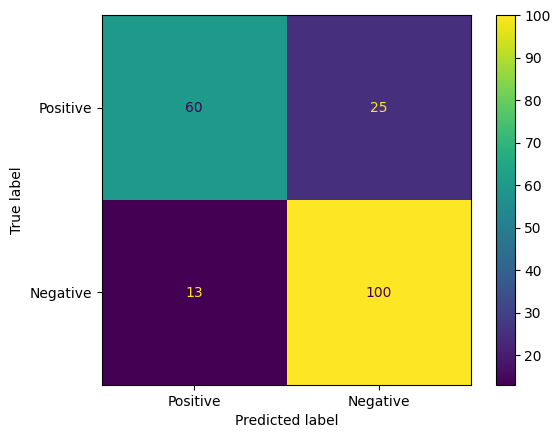

In [16]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_true, y_pred)
ConfusionMatrixDisplay(
  confusion_matrix=cm,
  display_labels=agile_classifier.labels,
).plot()

Finally, you can also look at the ROC curve to get a sense of potential prediction errors when using different scoring thresholds.

In [17]:
from sklearn.metrics import RocCurveDisplay, roc_curve


fpr, tpr, _ = roc_curve(y_true, y_score, pos_label=1)
RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

ValueError: y should be a 1d array, got an array of shape (198, 2) instead.